# Ancora grammatiche

## Tipo 2 (Context-free)

In [1]:
from liblet import Grammar, Derivation, ProductionGraph, iter2table, side_by_side

In [2]:
# pag 23

context_free = """
Sentence -> Name | List and Name
List -> Name , List | Name
Name -> tom | dick | harry
"""

steps = (1, 0), (2, 0), (3, 2), (4, 0), (5, 2), (6, 4)

Sentence -> List and Name -> Name , List and Name -> Name , Name and Name -> tom , Name and Name -> tom , dick and Name -> tom , dick and harry


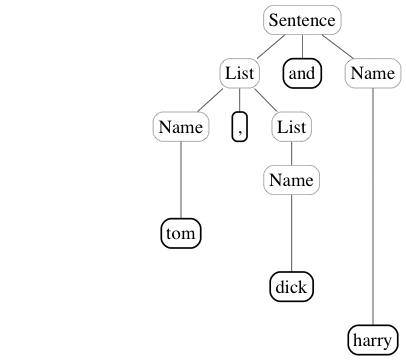

In [3]:
G_cf = Grammar.from_string(context_free) # non c'è più il False

d = Derivation(G_cf)
for step in steps: d = d.step(*step)
print(d)
ProductionGraph(d)

## Tipo 3 (Regolari)

In [4]:
# fig. 2.14, pag. 31

regular = """
Sentence -> tom | dick | harry | List
List -> tom ListTail | dick ListTail | harry ListTail
ListTail -> , List | and tom | and dick | and henry
"""

regular_strict = """
Sentence -> tom | dick | harry | List
List -> tom ListTail | dick ListTail | harry ListTail
ListTail -> , List | and Tom | and Dick | and Henry
Tom -> tom
Dick -> dick
Henry -> henry
"""

steps = (3, 0), (4, 0), (7, 1), (5, 2), (10, 3), (13, 4)

Sentence -> List -> tom ListTail -> tom , List -> tom , dick ListTail -> tom , dick and Henry -> tom , dick and henry


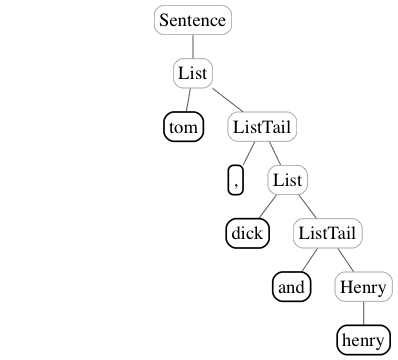

In [5]:
G_regular = Grammar.from_string(regular_strict)

d = Derivation(G_regular)
for step in steps: d = d.step(*step)
print(d)
ProductionGraph(d)

# Grammatiche come generatori

In [6]:
from liblet import Queue

def produce(G, max_steps = 1):
    Q = Queue([Derivation(G)])
    D = [] 
    step = 0
    while Q:
        if step > max_steps: break
        step += 1
        derivation = Q.dequeue()
        if set(derivation.sentential_form()) <= G.T: 
            D.append(derivation)
        for pos, nprod in derivation.possible_steps():
            Q.enqueue(derivation.step(pos, nprod))
    return D

In [7]:
G = Grammar.from_string("""
S -> a b c
S -> a S Q
b Q c -> b b c c
c Q -> Q c
""", False)

In [8]:
produce(G, 100)

[S -> a b c,
 S -> a S Q -> a a b c Q -> a a b Q c -> a a b b c c,
 S -> a S Q -> a a S Q Q -> a a a b c Q Q -> a a a b Q c Q -> a a a b b c c Q -> a a a b b c Q c -> a a a b b Q c c -> a a a b b b c c c]

# Fare pulizia nelle CF

In [9]:
from liblet import closure

@closure
def add_smaller(S):
    return S | {x - 1 for x in S if x > 0}

add_smaller({5})

{0, 1, 2, 3, 4, 5}

In [10]:
# fig 2.27, pag. 49

G = Grammar.from_string("""
S -> A B | D E
A -> a
B -> b C
C -> c
D -> d F 
E -> e 
F -> f D
""")
G

Grammar(N={A, B, C, D, E, F, S}, T={a, b, c, d, e, f}, P=(S -> A B, S -> D E, A -> a, B -> b C, C -> c, D -> d F, E -> e, F -> f D), S=S)

In [11]:
@closure
def productive(prod, G):
    for P in G.P:
        if set(P.rhs).issubset(prod): prod |= {P.lhs}
    return prod

productive(G.T, G)

frozenset({'A', 'B', 'C', 'E', 'S', 'a', 'b', 'c', 'd', 'e', 'f'})

In [12]:
@closure
def reachable(reach, G):
    for P in G.P:
        if P.lhs in reach: reach |= set(P.rhs)
    return reach
    
reachable({G.S}, G)   

{'A', 'B', 'C', 'D', 'E', 'F', 'S', 'a', 'b', 'c', 'd', 'e', 'f'}

In [13]:
G_small = Grammar.from_string("""
S -> A | a
A -> A B
B -> a
C -> a
""")

set(productive(G.T, G)), reachable({G.S}, G)

({'A', 'B', 'C', 'E', 'S', 'a', 'b', 'c', 'd', 'e', 'f'},
 {'A', 'B', 'C', 'D', 'E', 'F', 'S', 'a', 'b', 'c', 'd', 'e', 'f'})

# Homework


* modificare la procedura `produce` per i *context-free* in modo che usi solo 
  derivazioni *leftmost* (o *rightmost). Come si comporta tale versione sulle 
  grammatiche *context-sensitive*?

* Implementare una funzione `clean(G, good)` che data una grammatica `G` e un 
  insieme di   simboli `good` restituisca una nuova grammatica ottenuta cancellando 
  da `G` i simboli non in `good` e le produzioni in cui figurano.

  Se invocata su `G_small` e avendo `{'A', 'B', 'S', 'a'}` come insieme di simboli
  da preservare, la funzione restituisce la grammatica `Grammar(N={A, B, S}, T={a}, P=(S -> A, S -> a, A -> A B, B -> a), S=S)`
  
  Usando tale funzione, mostrare che, dati 
  
      G0 = clean(G, productive(G.T, G))
      G1 = clean(G0, reachable({G0.S}, G0))
      
      G2 = clean(G, reachable({G.S}, G))
      G3 = clean(G2, productive(G2.T, G2))

  si ha che `G1` e`G3` sono diverse, ossia che rimuovere prima gli improduttivi e poi 
  gli irraggiungibili, o viceversa, non porta alla stessa grammatica (e solo `G1` è
  una grammatica *propria*).

* Scrivete una grammatica *context-free* per $L=\{ ww^R | w \in T^* \}$ (dove con 
  $w^R$ si intende la stringa $w$ scritta al contrario), e una
  di tipo 1 *monotonica* per $L=\{ ww | w \in T^* \}$.

* Implementare una versione del *decoratore* `closure`.